##  Modeling the Impact of Three Different Parameters Application with Ensemble Simulations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

The Structure for Unifying Multiple Modeling Alternative (SUMMA) was developed to enable the controlled and systematic evaluation of multiple model representations of hydrologic process and scaling behavior (Clark et al., 2015a). SUMMA has several beneficial capabilities that assist with a unifying framework. 

This study looked at three different parameters application with ensemble simulations:

 |  Parameters      |  Min       |   Max       |   Step | Description |
 |:------------------:|------------|-------------|---------------------|:-------------|
  |theta_mp          |  0.30       |   0.60       | 0.10                | volumetric liquid water content when macropore flow begins (-)    |
  |rootDistExp       |  0.01      |   1.00       | 0.20               | exponent controlling the vertical distribution of root density (-)    |
 |summerLAI         |  0.01      |  10.0       | 2.00               | maximum leaf area index at the peak of the growing season (m2 m-2)    |



In this Jupyter Notebook, the pySUMMA library is used to show how to use pysumma to apply ensemble simulation for the different value of parameters combination. First, the three different parameters applications are described. Next, the Methods section describes how the pySUMMA can be used to apply ensemble simulations with three different parameters applications.  The Results section shows how to use pySUMMA and the Pandas library to display and compare the ensemble simulation outputs and observations.

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library.

## 2. Background

### 1) "theta_mp" parameter (volumetric liquid water content when macropore flow begins )

### 2) "rootDistExp" (exponent controlling the vertical distribution of root density)
 

### 3) "summerLAI" (maximum leaf area index at the peak of the growing season)

The above images are taken from the Stomal Resistance Method section within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Download SUMMA Model Instance from HydroShare

In [1]:
import pysumma as ps
import pysumma.hydroshare_utils as utils
from hs_restclient import HydroShare
import shutil, os
import subprocess

In [2]:
resource_id = '1f3f310af8364d2aa3e6a9459152a21c'
instance = utils.download_model_instance(resource_id)
instance

Username: choi
Password for choi: ········


'SummaModel_ReynoldsAspenStand_StomatalResistance_sopron'

In [3]:
!cd SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/; chmod +x ./installTestCases_local.sh
!cd SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/; ./installTestCases_local.sh

TestCases installed


### 2) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [4]:
from ipyleaflet import Map, GeoJSON
import json, os

In [5]:
m = Map(center=[43.06745, -116.75489], zoom=15)
instance = 'SummaModel_ReynoldsAspenStand_StomatalResistance_sopron'
with open(os.getcwd() + '/' + instance + '/data/reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### 3) Recreate Trial Parameters file(ParamTrial NetCDF) as SUMMA input

The trial parameters file is a NetCDF file that specifies model parameters for GRUs and individual HRUs. This enables the user to overwrite the default local parameters. Now pySUMMA has Python library to change local parameters file, however, 
there is no Python library to change the value of parameter variables in Trial Parameter NetCDF file. Therefore, in this process, we create the trial parameter file that dosen't have variables

<img src="SUMMA_parameters_spec_order.png">

In [6]:
import netCDF4 as nc

In [7]:
name = 'SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/settings/summa_zParamTrial_riparianAspen.nc'
param_trial = nc.Dataset(name, "w", format="NETCDF3_CLASSIC")
param_trial.createDimension("hru", 1)
param_trial.close()

### 4) Create pySUMMA Simulation Object and Set Simulation periods

In [1]:
# path to the SUMMA filemanager file
import os
instance = 'SummaModel_ReynoldsAspenStand_StomatalResistance_sopron'
file_manager = os.getcwd() + '/' + instance + '/settings/summa_fileManager_riparianAspenSimpleResistance.txt'

In [2]:
executable = "/code/bin/summa.exe"

In [3]:
# Create pySUMMA Simulation Object
import pysumma as ps
S = ps.Simulation(executable, file_manager)

In [4]:
# set the simulation start and finish times
S.decisions['simulStart'] = "2006-07-01 00:00"
S.decisions['simulFinsh'] = "2007-08-20 00:00"

In [5]:
S.decisions['stomResist'] = "Jarvis"

In [6]:
S.manager["output_prefix"].value = "different_parameters"

In [7]:
S._write_configuration()

### 5) Ensemble Application for Three Different Parameters Application

In [8]:
import numpy as np

In [9]:
def safe_arange(start, stop, step):
    a = np.arange(start, stop, step)
    result =[]
    for i in a:
        par = round(i, 10)
        result = np.append(result, par)
    return result

In [10]:
# create parameters ensemble
param_options = {
   'theta_mp': safe_arange(0.30, 0.60, 0.10),
   'rootDistExp': safe_arange(0.01, 1.00, 0.20),
   'summerLAI': safe_arange(0.01, 10.00, 2.00)
}

In [11]:
# create config for parameters ensemble
config = ps.ensemble.parameter_product(param_options)
len(config)

75

In [12]:
%%time
e = ps.Ensemble(executable, file_manager, config, num_workers=len(config))

CPU times: user 368 ms, sys: 203 ms, total: 572 ms
Wall time: 927 ms


In [13]:
%%time
e.run('local', prerun_cmds=['export OMP_NUM_THREADS=1','export LD_LIBRARY_PATH=/opt/local/lib'])

CPU times: user 9.87 s, sys: 1.71 s, total: 11.6 s
Wall time: 2min 33s


In [16]:
#e.monitor()
##check status
#for i, (n, s) in enumerate(e.simulations.items()):
#    if s.status != 'Success':
#        print(i, f'{n:100}', s.status)
## open output
#output_ensemble_decisions = e.merge_output()   

## 4. Results

In [14]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import numpy as np
jtplot.figsize(x=20, y=5)

In [15]:
# set output variable we want
output_variables = ['scalarCanopyTranspiration','scalarCanopyEvaporation','scalarGroundEvaporation']
# check output directory
output_path = S.manager["output_path"].value
# check SUMMA output file 
name_list = os.listdir(output_path)
full_list = [os.path.join(output_path,i) for i in name_list]
sorted_list = sorted(full_list)
run_suffix = 'different_parameters'
output_list = [x for x in sorted_list if run_suffix in x]

### 2) Create Pandas Dataframe for the first group of ensemble simulations

- (The first group) "theta_mp = 0.3" + others' combination

In [27]:
sim_start_date = "2006-07-01"
sim_end_date = "2007-08-20"
graph_start_date = "2007-06-01"
graph_end_date = "2007-08-20"
arr = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
H_index = pd.date_range(sim_start_date, sim_end_date, freq='1H')
total_et_f = pd.DataFrame(index=arr)
ensemble_list_all = []
for i, s_var in enumerate(output_list[0:25]):
    ds = xr.open_dataset(output_list[i])
    ensemble_list = output_list[i].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly
total_et_f.head()
total_et_f.to_excel("case_1.xlsx")

#### Add Observation data to compare with ensemble simulation

In [17]:
# create pySUMMA Plotting Object
Val_eddyFlux = xr.open_dataset(file_manager.split('/settings')[0]+'/data/validationData/ReynoldsCreek_eddyFlux.nc')
# read Total Evapotranspiration(LE-wpl) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux.variables['LE-wpl']
# create dates(X-axis) attribute from validation netcdf file
dates = Val_eddyFlux.coords['time'].data
# Change unit from Wm-2 to mm/hr (1 Wm-2 = 0.0864 MJm-2day-1, 1 MJm-2day-1 = 0.408 mmday-1, 1day = 24h)
data_values = Obs_Evapotranspitaton.data/2260000*3600*1.4   #*0.0864*0.408/24
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc[graph_start_date:graph_end_date]
# select aspen obervation station among three different stations
df_filt.columns = ['-','Observation (aspen)','-']
# resample data by the average for hour of day
df_gp_hr = df_filt.groupby([df_filt.index.hour, df_filt.index.minute]).mean()
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### Display SUMMA output for the first group of ensemble simulations

/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 

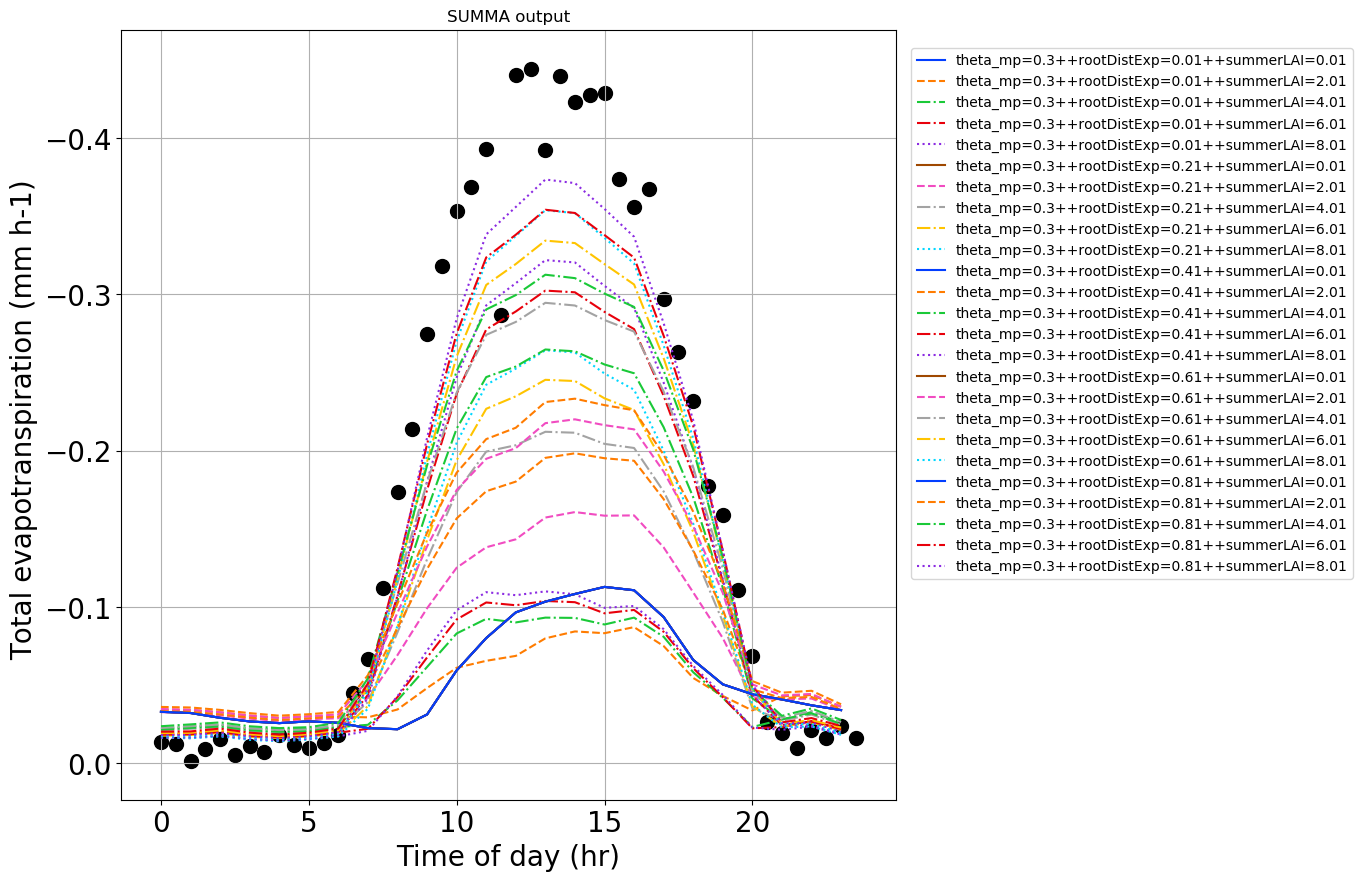

In [18]:
NUM_COLORS = 25
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

sns.reset_orig()  # get default matplotlib styles back
clrs = sns.color_palette("bright", n_colors=NUM_COLORS)  # a list of RGB tuples
fig, ax = plt.subplots(1,figsize=(10,10),linewidth=5.0)
for i in range(NUM_COLORS):
    lines = ax.plot(total_et_f[ensemble_list_all[i]].values)
    lines[0].set_color(clrs[i])
    lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
ax.invert_yaxis()
ax.set_title("SUMMA output")
#ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
#fig.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
fig.legend(labels=ensemble_list_all, loc='upper right', bbox_to_anchor=(1.36, 0.84))
plt.show()

### 3) Create Pandas Dataframe for the second group of ensemble simulations

- (The second group) "theta_mp = 0.4" + others' combination

In [28]:
sim_start_date = "2006-07-01"
sim_end_date = "2007-08-20"
graph_start_date = "2007-06-01"
graph_end_date = "2007-08-20"
arr = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
H_index = pd.date_range(sim_start_date, sim_end_date, freq='1H')
total_et_f = pd.DataFrame(index=arr)
ensemble_list_all = []
for i, s_var in enumerate(output_list[25:50]):
    ds = xr.open_dataset(output_list[i+25])
    ensemble_list = output_list[i+25].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly
total_et_f.head()
total_et_f.to_excel("case_2.xlsx")

#### Display SUMMA output for the second group of ensemble simulations

/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 

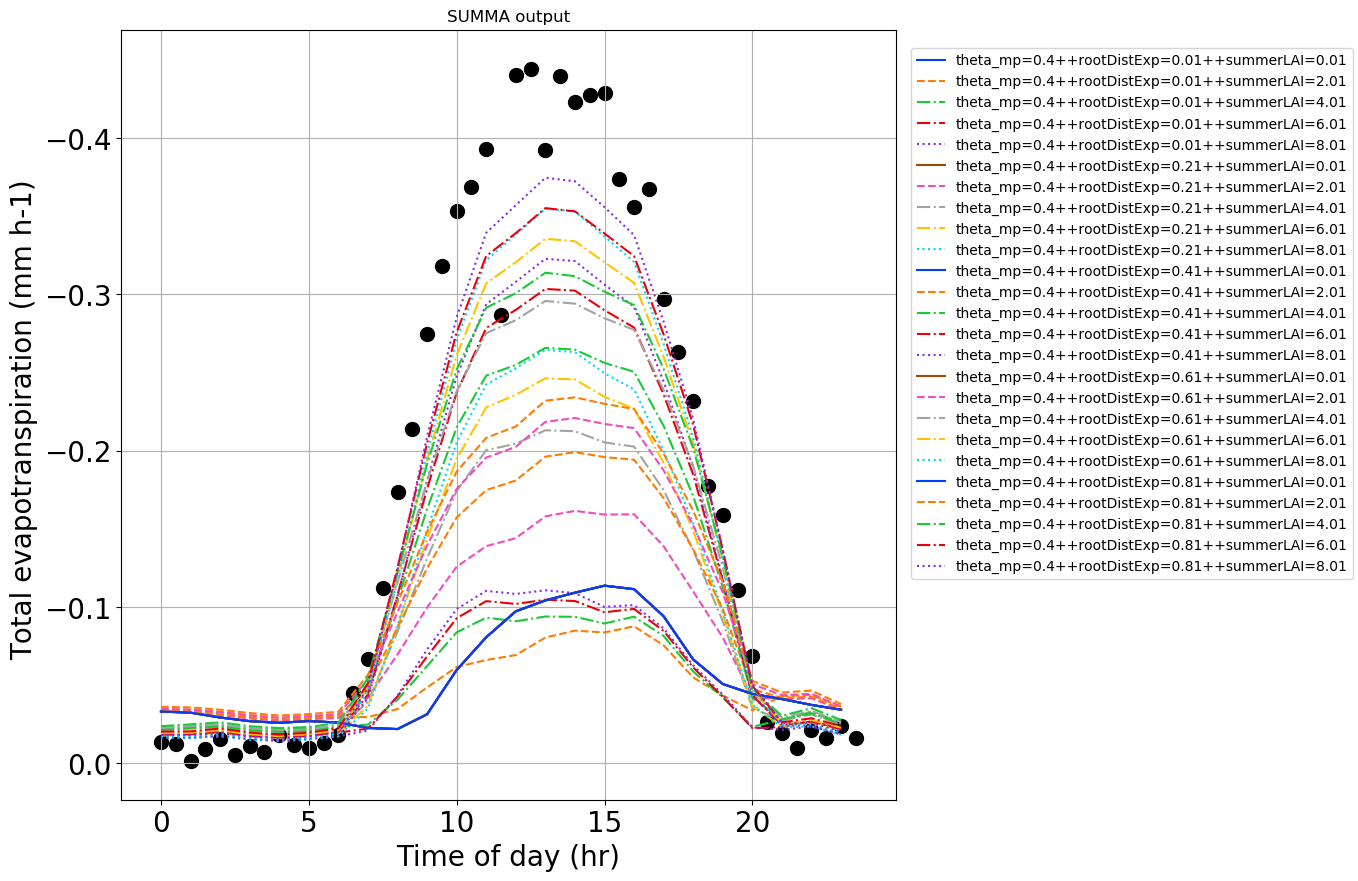

In [20]:
NUM_COLORS = 25
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

sns.reset_orig()  # get default matplotlib styles back
clrs = sns.color_palette("bright", n_colors=NUM_COLORS)  # a list of RGB tuples
fig, ax = plt.subplots(1,figsize=(10,10),linewidth=5.0)
for i in range(NUM_COLORS):
    lines = ax.plot(total_et_f[ensemble_list_all[i]].values)
    lines[0].set_color(clrs[i])
    lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
ax.invert_yaxis()
ax.set_title("SUMMA output")
#ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
#fig.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
fig.legend(labels=ensemble_list_all, loc='upper right', bbox_to_anchor=(1.36, 0.84))
plt.show()

### 4) Create Pandas Dataframe for the third group of ensemble simulations

- (The third group) "theta_mp = 0.5" + others' combination

In [29]:
sim_start_date = "2006-07-01"
sim_end_date = "2007-08-20"
graph_start_date = "2007-06-01"
graph_end_date = "2007-08-20"
arr = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
H_index = pd.date_range(sim_start_date, sim_end_date, freq='1H')
total_et_f = pd.DataFrame(index=arr)
ensemble_list_all = []
for i, s_var in enumerate(output_list[50:75]):
    ds = xr.open_dataset(output_list[i+50])
    ensemble_list = output_list[i+50].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly
total_et_f.head()
total_et_f.to_excel("case_3.xlsx")

#### Display SUMMA output for the third group of ensemble simulations

/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 

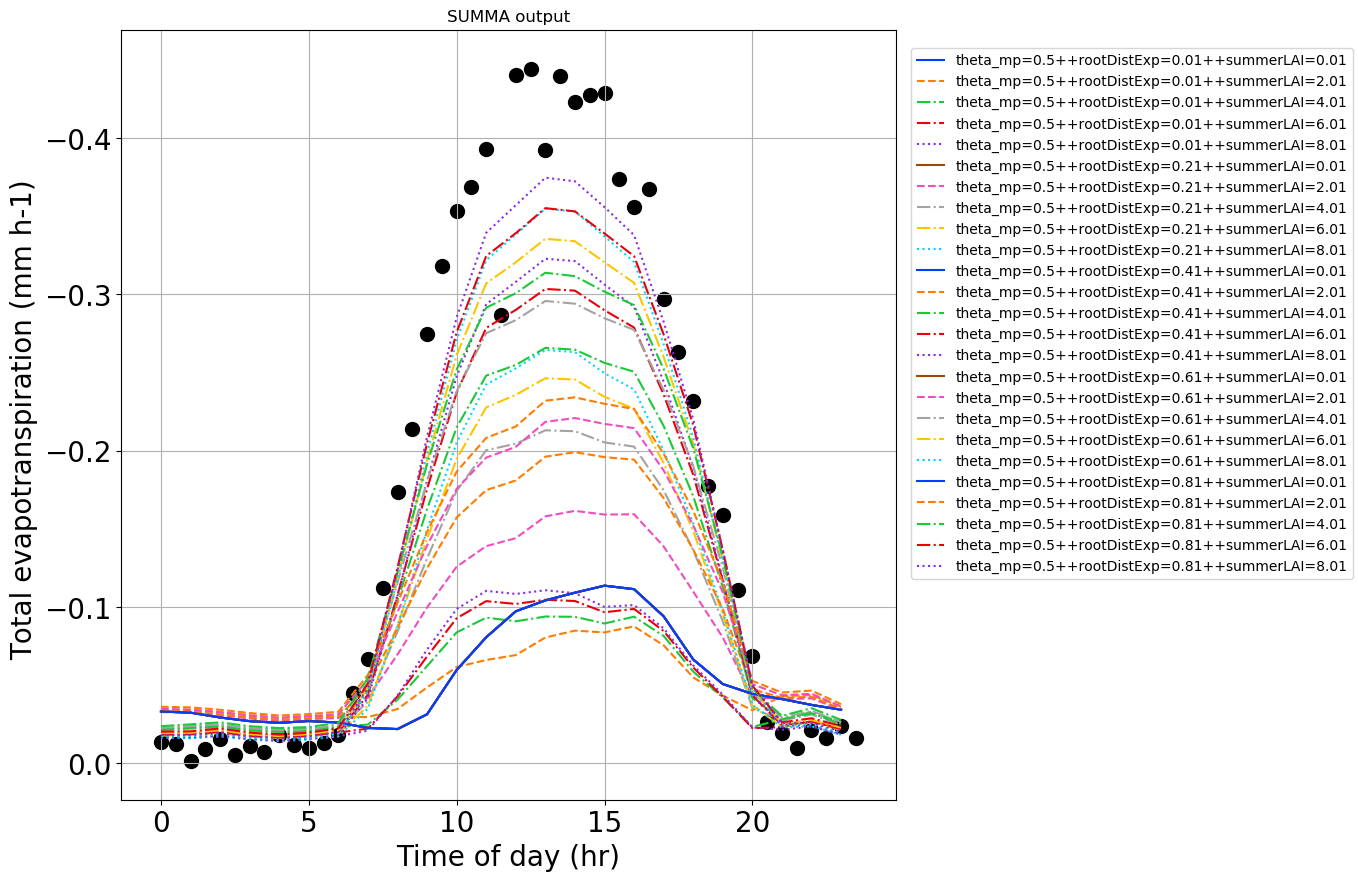

In [23]:
NUM_COLORS = 25
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

sns.reset_orig()  # get default matplotlib styles back
clrs = sns.color_palette("bright", n_colors=NUM_COLORS)  # a list of RGB tuples
fig, ax = plt.subplots(1,figsize=(10,10),linewidth=5.0)
for i in range(NUM_COLORS):
    lines = ax.plot(total_et_f[ensemble_list_all[i]].values)
    lines[0].set_color(clrs[i])
    lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
ax.invert_yaxis()
ax.set_title("SUMMA output")
#ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
#fig.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
fig.legend(labels=ensemble_list_all, loc='upper right', bbox_to_anchor=(1.36, 0.84))
plt.show()